In [1]:
# ==============================
# 데이터 로딩 작업
# ==============================
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

# ==============================
# 시드 고정
# ==============================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ==============================
# 토큰 정의
# ==============================
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"

# ------------------------------
# Dataset 정의 (Reverse 옵션 추가, padding은 collate_fn에서 처리)
# ------------------------------
class DateDataset(Dataset):
    def __init__(self, samples, src_stoi=None, tgt_stoi=None, reverse=True):
        self.samples = samples
        self.reverse = reverse

        # 입력 문자 사전
        if src_stoi is None:
            src_vocab = set("".join(s for s, _ in self.samples))
            src_tokens = [PAD, SOS, EOS] + sorted(src_vocab)
            self.src_stoi = {s: i for i, s in enumerate(src_tokens)}
        else:
            self.src_stoi = src_stoi
        self.src_itos = {i: s for s, i in self.src_stoi.items()}

        # 출력 문자 사전
        if tgt_stoi is None:
            tgt_vocab = set("".join(t for _, t in self.samples))
            tgt_tokens = [PAD, SOS, EOS] + sorted(tgt_vocab)
            self.tgt_stoi = {s: i for i, s in enumerate(tgt_tokens)}
        else:
            self.tgt_stoi = tgt_stoi
        self.tgt_itos = {i: s for s, i in self.tgt_stoi.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        src, tgt = self.samples[idx]

        # Reverse Option 적용
        if self.reverse:
            src = src[::-1]

        # 인덱스 변환 (패딩은 collate_fn에서 처리)
        src_ids = [self.src_stoi[SOS]] + [self.src_stoi[c] for c in src] + [self.src_stoi[EOS]]
        tgt_ids = [self.tgt_stoi[SOS]] + [self.tgt_stoi[c] for c in tgt] + [self.tgt_stoi[EOS]]

        return torch.tensor(src_ids), torch.tensor(tgt_ids), src, tgt


# ------------------------------
# collate_fn: 배치 단위 padding
# ------------------------------
def collate_fn(batch):
    src_batch, tgt_batch, src_strs, tgt_strs = zip(*batch)

    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=train_dataset.src_stoi[PAD])
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=train_dataset.tgt_stoi[PAD])

    return src_batch, tgt_batch, src_strs, tgt_strs


# ==============================
# 데이터셋 불러오기
# ==============================
all_samples = []
with open("date.txt", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        src, tgt = line.split("_")
        all_samples.append((src.strip(), tgt.strip()))

train_samples, test_samples = train_test_split(all_samples, test_size=0.2, random_state=42)

train_dataset = DateDataset(train_samples, reverse=False)
test_dataset = DateDataset(test_samples,
                           src_stoi=train_dataset.src_stoi,
                           tgt_stoi=train_dataset.tgt_stoi,
                           reverse=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

# ==============================
# 데이터 예시 출력
# ==============================
for src_batch, tgt_batch, src_strs, tgt_strs in train_loader:
    print("입력 배치 shape:", src_batch.shape)
    print("출력 배치 shape:", tgt_batch.shape)
    print("첫 번째 샘플 원문:", src_strs[0], "→", tgt_strs[0])
    print("첫 번째 입력 인덱스:", src_batch[0][:20].tolist())
    print("첫 번째 출력 인덱스:", tgt_batch[0][:20].tolist())
    break


Device: cuda:9
입력 배치 shape: torch.Size([128, 30])
출력 배치 shape: torch.Size([128, 12])
첫 번째 샘플 원문: feb 11, 2011 → 2011-02-11
첫 번째 입력 인덱스: [1, 43, 42, 39, 3, 7, 7, 4, 3, 8, 6, 7, 7, 2, 0, 0, 0, 0, 0, 0]
첫 번째 출력 인덱스: [1, 6, 4, 5, 5, 3, 4, 6, 3, 5, 5, 2]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# ----------------------------------------------------------
# Encoder
# ----------------------------------------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, num_layers,
            batch_first=True
        )

    def forward(self, src):
        # src: [B, S]
        embedded = self.embedding(src)                        # [B, S, E]
        encoder_outputs, (hidden, cell) = self.lstm(embedded) # encoder_outputs: [B, S, H]
        return encoder_outputs, hidden, cell


# ----------------------------------------------------------
# Luong Attention (dot-product)
# ----------------------------------------------------------
class LuongAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, decoder_state, encoder_outputs):
        """
        decoder_state: [B, H] (현재 디코더 hidden state)
        encoder_outputs: [B, S, H] (인코더 전체 출력)
        """
        # score = h_t^T * h_s  (batch matrix multiplication)
        scores = torch.bmm(encoder_outputs, decoder_state.unsqueeze(2)).squeeze(2)  # [B, S]
        attn_weights = F.softmax(scores, dim=-1)                                    # [B, S]

        # context 벡터: attention weights * encoder_outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [B, H]
        return attn_weights, context


# ----------------------------------------------------------
# Decoder with Attention
# ----------------------------------------------------------
class LuongDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers=1, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, num_layers,
            batch_first=True
        )
        self.attn = LuongAttention()

        self.fc_out = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, input_token, hidden, cell, encoder_outputs):
        # input_token: [B]
        emb = self.embedding(input_token).unsqueeze(1)        # [B, 1, E]
        out, (hidden, cell) = self.lstm(emb, (hidden, cell))  # out: [B, 1, H]
        dec_state = hidden[-1]                                # [B, H]

        attn_weights, context = self.attn(dec_state, encoder_outputs)
        combined = torch.cat([out.squeeze(1), context], dim=-1)  # [B, 2H]
        prediction = self.fc_out(combined)                       # [B, vocab]

        return prediction, hidden, cell, attn_weights


# ----------------------------------------------------------
# Seq2Seq with Attention
# ----------------------------------------------------------
class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=1.0):
        """
        src: [B, S]
        trg: [B, T]
        """
        B, T = trg.size()
        vocab_size = self.decoder.fc_out[-1].out_features
        outputs = torch.zeros(B, T, vocab_size, device=self.device)

        encoder_outputs, hidden, cell = self.encoder(src)
        input_token = trg[:, 0]  # 첫 입력은 <SOS>

        for t in range(1, T):
            pred, hidden, cell, _ = self.decoder(
                input_token, hidden, cell, encoder_outputs
            )
            outputs[:, t] = pred

            # Teacher Forcing 여부 결정
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = pred.argmax(1)
            input_token = trg[:, t] if teacher_force else top1

        return outputs


In [3]:
@torch.no_grad()
def greedy_decode_attn(model, src, max_len, tgt_stoi, tgt_itos, debug=False):
    model.eval()

    # 인코더 실행
    encoder_outputs, hidden, cell = model.encoder(src)

    # <SOS> 시작
    input_token = torch.tensor([tgt_stoi["<SOS>"]], device=src.device)
    outputs = []
    attn_matrix = []

    for t in range(max_len):
        pred, hidden, cell, attn_weights = model.decoder(
            input_token, hidden, cell, encoder_outputs
        )
        top1 = pred.argmax(1)

        if debug:
            print(f"Step {t}: {tgt_itos[top1.item()]} | Attn={attn_weights.cpu().numpy()}")

        # 종료 조건
        if top1.item() == tgt_stoi["<EOS>"]:
            break
        if top1.item() not in (tgt_stoi["<SOS>"], tgt_stoi["<PAD>"]):
            outputs.append(top1.item())

        # 어텐션 가중치 기록
        attn_matrix.append(attn_weights.squeeze(0).cpu().numpy())

        # 다음 입력
        input_token = top1

    return outputs, attn_matrix


@torch.no_grad()
def evaluate_attn_seq2seq(
    model, x_str, src_stoi, tgt_stoi, tgt_itos,
    device, max_len=20, debug=False, return_attn=False
):
    # 문자열 → 인덱스 변환
    x_idx = [src_stoi.get(c, src_stoi["<PAD>"]) for c in x_str]
    src = torch.tensor(x_idx, device=device).unsqueeze(0)  # [1, L]

    # Greedy decoding (with attention)
    pred_idx, attn_matrix = greedy_decode_attn(
        model, src, max_len, tgt_stoi, tgt_itos, debug=debug
    )

    pred_str = "".join([tgt_itos[i] for i in pred_idx])

    if return_attn:
        return pred_str, attn_matrix
    else:
        return pred_str


In [4]:
# -------------------------------
# 하이퍼파라미터
# -------------------------------
INPUT_DIM = len(train_dataset.src_stoi)
OUTPUT_DIM = len(train_dataset.tgt_stoi)

PAD_IDX = train_dataset.tgt_stoi["<PAD>"]
SOS_IDX = train_dataset.tgt_stoi["<SOS>"]
EOS_IDX = train_dataset.tgt_stoi["<EOS>"]

EMB_DIM = 64          # 임베딩 차원
HIDDEN_DIM = 256      # LSTM 은닉 차원
N_EPOCHS = 50
PATIENCE = 15         # early stopping patience
MIN_DELTA = 1e-3
CLIP = 5.0

# Teacher Forcing Ratio 스케줄링
TF_START = 0.7
TF_END   = 0.3
TF_DECAY = 0.02
# -------------------------------
# 모델 초기화 (Luong Attention)
# -------------------------------
enc = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM).to(device)
dec = LuongDecoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM).to(device)
model = Seq2SeqAttn(enc, dec, device).to(device)

# -------------------------------
# 손실 함수 & 옵티마이저
# -------------------------------
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [5]:
#평가 지표
def token_accuracy_fn(y_pred, y_true, pad_idx):
    pred_tokens = y_pred.argmax(dim=2)  # [B, T]
    mask = (y_true != pad_idx)
    correct = (pred_tokens == y_true) & mask
    acc = correct.sum().float() / mask.sum().float()
    return acc.item()

@torch.no_grad()
@torch.no_grad()
def exact_match_fn(model, dataset, src_stoi, tgt_stoi, tgt_itos, device, n_samples=None):
    correct = 0
    """
    n_samples=None → 전체 데이터셋 평가
    n_samples=숫자 → 그 수만큼 랜덤 샘플 평가
    """
    if n_samples is None or n_samples >= len(dataset):
        indices = range(len(dataset))
    else:
        indices = random.sample(range(len(dataset)), n_samples)

        
    for idx in indices:
        _, _, src_str, tgt_str = dataset[idx]
        
        # pred_str, attn_weights 둘 다 반환 → 문자열만 사용
        result = evaluate_attn_seq2seq(
            model, src_str,
            src_stoi=src_stoi, tgt_stoi=tgt_stoi, tgt_itos=tgt_itos,
            device=device, max_len=len(tgt_str)+2
        )
        if isinstance(result, tuple):  # (pred_str, attn_weights)
            pred_str = result[0]
        else:  # 그냥 문자열일 때
            pred_str = result
        
        if pred_str.replace(" ", "") == tgt_str:
            correct += 1
    return correct / len(indices)




In [6]:
from tqdm import tqdm

#: 학습 / 평가 함수

def train_one_epoch(model, loader, optimizer, criterion, epoch, clip=5.0):
    model.train()
    total_loss = total_acc = 0.0
    # teacher forcing ratio 선형 감소
    tf_ratio = max(TF_END, TF_START - TF_DECAY * epoch)
    
    for src, trg, _, _ in tqdm(loader, desc=f"Train Epoch {epoch}", leave=False):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg, teacher_forcing_ratio=1.0) #고정 1.0 아니면 tf_ration사용

        V = output.shape[-1]
        output_flat = output[:, 1:].reshape(-1, V)
        trg_flat = trg[:, 1:].reshape(-1)

        loss = criterion(output_flat, trg_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        B = src.size(0)
        Tm1 = trg[:, 1:].size(1)
        output_eval = output_flat.view(B, Tm1, V)
        trg_eval = trg[:, 1:]
        acc = token_accuracy_fn(output_eval, trg_eval, pad_idx=PAD_IDX)

        total_loss += loss.item()
        total_acc += acc

    n = len(loader)
    return total_loss / n, total_acc / n



@torch.no_grad()
def evaluate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = total_acc = 0.0

    for src, trg, _, _ in loader:
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg, teacher_forcing_ratio=0.0)

        V = output.shape[-1]
        output_flat = output[:, 1:].reshape(-1, V)
        trg_flat = trg[:, 1:].reshape(-1)

        loss = criterion(output_flat, trg_flat)

        B = src.size(0)
        Tm1 = trg[:, 1:].size(1)
        output_eval = output_flat.view(B, Tm1, V)
        trg_eval = trg[:, 1:]

        total_loss += loss.item()
        total_acc += token_accuracy_fn(output_eval, trg_eval, pad_idx=PAD_IDX)

    n = len(loader)
    return total_loss / n, total_acc / n


In [7]:
# ==============================
# 학습 루프 (Exact Match 기반 Early Stopping)
# ==============================

train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_exact_accs = []   # train_exact_accs [] 제거

best_val_eacc = 0.0
patience_counter = 0

for epoch in range(1, N_EPOCHS + 1):
    # ------------------------------
    # 1) 학습 / 평가
    # ------------------------------
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    va_loss, va_acc = evaluate_one_epoch(model, test_loader, criterion)
    
    # # Train Exact Match는 생략
    # tr_eacc = exact_match_fn(
    #     model, train_dataset,
    #     src_stoi=train_dataset.src_stoi,
    #     tgt_stoi=train_dataset.tgt_stoi,
    #     tgt_itos=train_dataset.tgt_itos,
    #     device=device, n_samples=500
    # )
    #
    #validation은 전체 데이터셋으로 평가
    va_eacc = exact_match_fn(
        model, test_dataset,
        src_stoi=train_dataset.src_stoi,
        tgt_stoi=train_dataset.tgt_stoi,
        tgt_itos=test_dataset.tgt_itos,
        device=device,
        n_samples=None   # None → 전체 데이터 평가
    )

    # ------------------------------
    # 2) 기록
    # ------------------------------
    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc); val_accs.append(va_acc)
    val_exact_accs.append(va_eacc)

    print(f"Epoch {epoch:03d} | "
          f"Train Loss: {tr_loss:.5f} | Token Acc: {tr_acc:.5f} || "
          f"Val Loss: {va_loss:.5f} | Token Acc: {va_acc:.5f} | Exact Acc: {va_eacc:.5f} "
          f"(Best Val Exact: {best_val_eacc:.5f}, Patience: {patience_counter})")

    # ------------------------------
    # 3) 샘플 디버그 출력
    # ------------------------------
    if epoch % 1 == 0:
        src_ids, tgt_ids, src_str, tgt_str = random.choice(test_dataset)
        pred = evaluate_attn_seq2seq(
            model, src_str,
            src_stoi=train_dataset.src_stoi,
            tgt_stoi=train_dataset.tgt_stoi,
            tgt_itos=train_dataset.tgt_itos,
            device=device,
            max_len=len(tgt_str) + 2,
            return_attn=False   #  문자열만
        )
        print(f"[DEBUG] 입력: {src_str} | 정답: {tgt_str} | 예측: {pred}")

    # ------------------------------
    # 4) Early Stopping (Exact Match 기준)
    # ------------------------------
    if va_eacc > best_val_eacc + MIN_DELTA:
        best_val_eacc = va_eacc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered!")
            break


Epoch 001 | Train Loss: 0.28905 | Token Acc: 0.91019 || Val Loss: 0.00085 | Token Acc: 1.00000 | Exact Acc: 0.57400 (Best Val Exact: 0.00000, Patience: 0)
[DEBUG] 입력: Tuesday, June 27, 2017 | 정답: 2017-06-27 | 예측: 2011-06-27


Epoch 002 | Train Loss: 0.00708 | Token Acc: 0.99853 || Val Loss: 0.00028 | Token Acc: 1.00000 | Exact Acc: 0.85890 (Best Val Exact: 0.57400, Patience: 0)
[DEBUG] 입력: 10/30/98 | 정답: 1998-10-30 | 예측: 1998-00-30


Epoch 003 | Train Loss: 0.00011 | Token Acc: 1.00000 || Val Loss: 0.00004 | Token Acc: 1.00000 | Exact Acc: 0.87830 (Best Val Exact: 0.85890, Patience: 0)
[DEBUG] 입력: 10/25/13 | 정답: 2013-10-25 | 예측: 2011-10-25


Epoch 004 | Train Loss: 0.00002 | Token Acc: 1.00000 || Val Loss: 0.00002 | Token Acc: 1.00000 | Exact Acc: 0.88160 (Best Val Exact: 0.87830, Patience: 0)
[DEBUG] 입력: Friday, January 18, 2008 | 정답: 2008-01-18 | 예측: 2008-01-18


Epoch 005 | Train Loss: 0.00001 | Token Acc: 1.00000 || Val Loss: 0.00001 | Token Acc: 1.00000 | Exact Acc: 0.88300 (Best Val Exact: 0.88160, Patience: 0)
[DEBUG] 입력: SEPTEMBER 29, 1978 | 정답: 1978-09-29 | 예측: 1978-09-29


Epoch 006 | Train Loss: 0.00001 | Token Acc: 1.00000 || Val Loss: 0.00001 | Token Acc: 1.00000 | Exact Acc: 0.88390 (Best Val Exact: 0.88300, Patience: 0)
[DEBUG] 입력: May 6, 2012 | 정답: 2012-05-06 | 예측: 2012-05-06


Epoch 007 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.88460 (Best Val Exact: 0.88300, Patience: 1)
[DEBUG] 입력: Feb 19, 1972 | 정답: 1972-02-19 | 예측: 1972-02-19


Epoch 008 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87730 (Best Val Exact: 0.88460, Patience: 0)
[DEBUG] 입력: SEP 24, 1976 | 정답: 1976-09-24 | 예측: 1976-09-24


Epoch 009 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87740 (Best Val Exact: 0.88460, Patience: 1)
[DEBUG] 입력: february 1, 1982 | 정답: 1982-02-01 | 예측: 1982-02-01


Epoch 010 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87780 (Best Val Exact: 0.88460, Patience: 2)
[DEBUG] 입력: Saturday, June 26, 1993 | 정답: 1993-06-26 | 예측: 1993-06-26


Epoch 011 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87800 (Best Val Exact: 0.88460, Patience: 3)
[DEBUG] 입력: friday, may 28, 1999 | 정답: 1999-05-28 | 예측: 1999-05-28


Epoch 012 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87790 (Best Val Exact: 0.88460, Patience: 4)
[DEBUG] 입력: Sunday, July 26, 2009 | 정답: 2009-07-26 | 예측: 2009-07-26


Epoch 013 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87840 (Best Val Exact: 0.88460, Patience: 5)
[DEBUG] 입력: OCT 7, 1991 | 정답: 1991-10-07 | 예측: 1991-10-07


Epoch 014 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87920 (Best Val Exact: 0.88460, Patience: 6)
[DEBUG] 입력: Monday, August 28, 1978 | 정답: 1978-08-28 | 예측: 1978-08-28


Epoch 015 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87920 (Best Val Exact: 0.88460, Patience: 7)
[DEBUG] 입력: monday, january 7, 1985 | 정답: 1985-01-07 | 예측: 1985-01-07


Epoch 016 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87970 (Best Val Exact: 0.88460, Patience: 8)
[DEBUG] 입력: may 18, 1986 | 정답: 1986-05-18 | 예측: 1986-05-18


Epoch 017 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.88020 (Best Val Exact: 0.88460, Patience: 9)
[DEBUG] 입력: July 29, 1983 | 정답: 1983-07-29 | 예측: 1983-07-29


Epoch 018 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87980 (Best Val Exact: 0.88460, Patience: 10)
[DEBUG] 입력: APR 18, 2007 | 정답: 2007-04-18 | 예측: 2007-04-18


Epoch 019 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.87970 (Best Val Exact: 0.88460, Patience: 11)
[DEBUG] 입력: Feb 15, 2005 | 정답: 2005-02-15 | 예측: 2005-02-15


Epoch 020 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.88000 (Best Val Exact: 0.88460, Patience: 12)
[DEBUG] 입력: mar 2, 2017 | 정답: 2017-03-02 | 예측: 2017-03-02


Epoch 021 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.88050 (Best Val Exact: 0.88460, Patience: 13)
[DEBUG] 입력: 4/3/70 | 정답: 1970-04-03 | 예측: 1970-04-03


Epoch 022 | Train Loss: 0.00000 | Token Acc: 1.00000 || Val Loss: 0.00000 | Token Acc: 1.00000 | Exact Acc: 0.88050 (Best Val Exact: 0.88460, Patience: 14)
[DEBUG] 입력: Dec 2, 1983 | 정답: 1983-12-02 | 예측: 1983-12-02
Early stopping triggered!


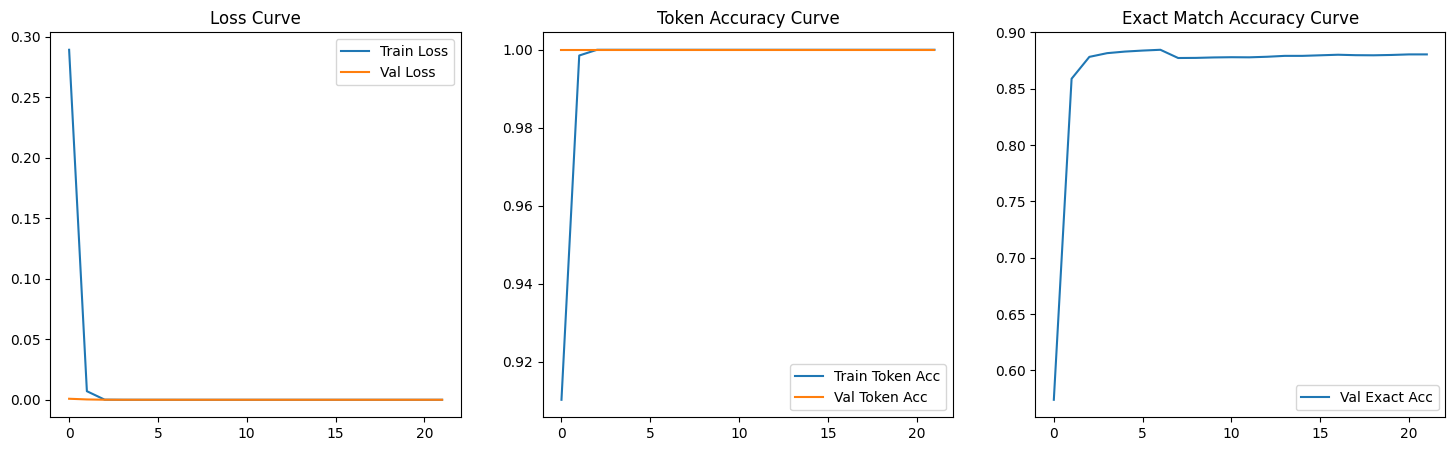

훈련 결과, 그래프, 모델 가중치, 메타정보를 'results_seq2seq_attention_date_normal' 폴더에 저장했습니다.


In [9]:
###
# ----------------------------------------------------------
# 학습 완료 후 결과 저장
# ----------------------------------------------------------

import os
import json
import matplotlib.pyplot as plt
import pickle

# 저장 디렉토리 생성
save_dir = "results_seq2seq_attention_date_normal"
os.makedirs(save_dir, exist_ok=True)

# 1) 학습 로그 (loss, acc 기록) 저장
history = {
    "train_losses": [float(x) for x in train_losses],
    "val_losses": [float(x) for x in val_losses],
    "train_accs": [float(x) for x in train_accs],
    "val_accs": [float(x) for x in val_accs],
    "val_exact_accs": [float(x) for x in val_exact_accs],
}
with open(os.path.join(save_dir, "history.json"), "w") as f:
    json.dump(history, f, indent=2)

# 2) 학습 곡선 그래프
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,3,2)
plt.plot(train_accs, label="Train Token Acc")
plt.plot(val_accs, label="Val Token Acc")
plt.legend(); plt.title("Token Accuracy Curve")

plt.subplot(1,3,3)
plt.plot(val_exact_accs, label="Val Exact Acc")
plt.legend(); plt.title("Exact Match Accuracy Curve")

plt.savefig(os.path.join(save_dir, "training_curves.png"), dpi=200, bbox_inches="tight")
plt.show()
plt.close()

# 3) 모델 가중치 저장
torch.save(model.state_dict(), os.path.join(save_dir, "results_seq2seq_attention_date_normal.pt"))

# 4) 메타 정보 저장 (옵션)
meta = {
    "input_dim": INPUT_DIM,
    "output_dim": OUTPUT_DIM,
    "emb_dim": EMB_DIM,
    "hidden_dim": HIDDEN_DIM,
    "n_epochs": N_EPOCHS,
    "best_val_exact": max(val_exact_accs) if val_exact_accs else None
}
with open(os.path.join(save_dir, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)


# 5) stoi / itos 저장
with open(os.path.join(save_dir, "src_stoi.pkl"), "wb") as f:
    pickle.dump(train_dataset.src_stoi, f)
with open(os.path.join(save_dir, "src_itos.pkl"), "wb") as f:
    pickle.dump(train_dataset.src_itos, f)

with open(os.path.join(save_dir, "tgt_stoi.pkl"), "wb") as f:
    pickle.dump(train_dataset.tgt_stoi, f)
with open(os.path.join(save_dir, "tgt_itos.pkl"), "wb") as f:
    pickle.dump(train_dataset.tgt_itos, f)


print(f"훈련 결과, 그래프, 모델 가중치, 메타정보를 '{save_dir}' 폴더에 저장했습니다.")



In [10]:
# ==============================
# 문자열 정리 함수 (PAD, SOS, EOS 제거)
# ==============================
def clean_str(s: str):
    return s.replace(SOS, "").replace(EOS, "").replace(PAD, "").strip()


# ==============================
# 날짜 변환 예시 출력 (테스트 데이터 랜덤 5개)
# ==============================
@torch.no_grad()
def show_examples_date(model, test_data, n=5):
    indices = random.sample(range(len(test_data)), n)
    print("\n=== 날짜 변환 예시 (Seq2Seq) ===")
    for idx in indices:
        _, _, src_str, tgt_str = test_data[idx]

        pred_raw = evaluate_attn_seq2seq(
            model, src_str,
            src_stoi=train_dataset.src_stoi,
            tgt_stoi=train_dataset.tgt_stoi,
            tgt_itos=train_dataset.tgt_itos,
            device=device,
            max_len=len(tgt_str) + 5
        )

        pred_str = clean_str(pred_raw)
        true_str = clean_str(tgt_str)

        print(f"입력: {src_str:<30} | 정답: {true_str:<12} | 예측: {pred_str:<12}")


# ------------------------------
# 실행: 테스트 데이터 무작위 5개
# ------------------------------
show_examples_date(model, test_dataset, n=5)


# ==============================
# Custom Examples 직접 확인
# ==============================
custom_examples = [
    "september 27, 1994",
    "August 19, 2003",
    "2/10/93",
    "10/31/90",
    "TUESDAY, SEPTEMBER 25, 1984",
    "JUN 17, 2013",
    "april 3, 1996",
    "October 24, 1974"
]

print("\n=== Custom 예시 입력 (Seq2Seq) ===")
for x in custom_examples:
    pred_raw = evaluate_attn_seq2seq(
        model, x,
        src_stoi=train_dataset.src_stoi,
        tgt_stoi=train_dataset.tgt_stoi,
        tgt_itos=train_dataset.tgt_itos,
        device=device,
        max_len=15   # YYYY-MM-DD 형태까지 넉넉히
    )

    pred_str = clean_str(pred_raw)
    print(f"입력: {x:<30} | 예측: {pred_str}")



=== 날짜 변환 예시 (Seq2Seq) ===
입력: FEBRUARY 9, 1972               | 정답: 1972-02-09   | 예측: 1972-02-09  
입력: jun 27, 2016                   | 정답: 2016-06-27   | 예측: 2016-06-27  
입력: TUESDAY, JUNE 17, 1986         | 정답: 1986-06-17   | 예측: 1986-06-17  
입력: 2/28/05                        | 정답: 2005-02-28   | 예측: 2005-02-28  
입력: Monday, February 16, 1976      | 정답: 1976-02-16   | 예측: 1976-02-16  

=== Custom 예시 입력 (Seq2Seq) ===
입력: september 27, 1994             | 예측: 1994-09-27
입력: August 19, 2003                | 예측: 2003-08-19
입력: 2/10/93                        | 예측: 1993-02-10
입력: 10/31/90                       | 예측: 1990-10-31
입력: TUESDAY, SEPTEMBER 25, 1984    | 예측: 1984-09-25
입력: JUN 17, 2013                   | 예측: 2013-06-17
입력: april 3, 1996                  | 예측: 1996-04-03
입력: October 24, 1974               | 예측: 1974-10-24


입력 : FRIDAY, AUGUST 26, 1983
예측 : 1983-08-26


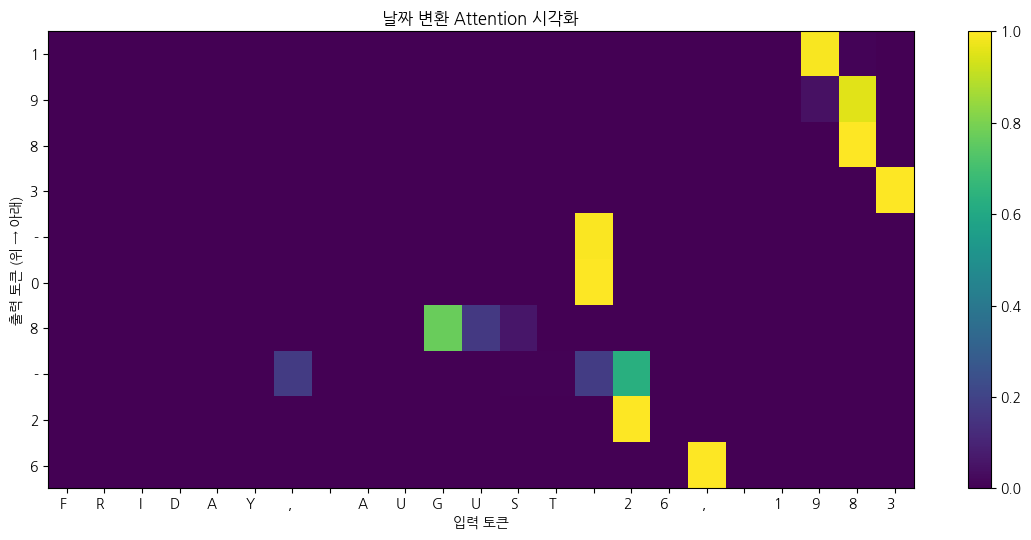

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import koreanize_matplotlib


# ----------------------------------------------------------
# Greedy decoding with attention (mask 사용 안함)
# ----------------------------------------------------------
@torch.no_grad()
def greedy_decode_attn(model, src, max_len, tgt_stoi, tgt_itos, debug=False):
    """
    model: Seq2SeqAttn 모델
    src: [1, S] (src_stoi로 인덱싱된 입력)
    max_len: 최대 디코딩 길이
    tgt_stoi, tgt_itos: 타겟 문자 사전
    반환: (pred_idx, attn_matrix)
      - pred_idx: 예측된 토큰 인덱스 리스트
      - attn_matrix: [T, S] 어텐션 가중치 행렬
    """
    model.eval()
    encoder_outputs, hidden, cell = model.encoder(src)

    # 첫 입력은 <SOS>
    input_token = torch.tensor([tgt_stoi["<SOS>"]], device=src.device)
    pred_idx = []
    attn_rows = []

    for _ in range(max_len):
        pred, hidden, cell, attn_weights = model.decoder(
            input_token, hidden, cell, encoder_outputs
        )  # attn_weights: [1, S]

        top1 = pred.argmax(1)

        # 어텐션 행렬 저장
        attn_rows.append(attn_weights.squeeze(0).cpu().numpy())

        # 종료 조건
        if top1.item() == tgt_stoi["<EOS>"]:
            break
        if top1.item() != tgt_stoi["<SOS>"]:
            pred_idx.append(top1.item())

        input_token = top1

    attn_matrix = np.stack(attn_rows, axis=0) if attn_rows else np.zeros((0, src.size(1)))
    return pred_idx, attn_matrix


# ----------------------------------------------------------
# evaluate 함수 (이미 정의된 것 재사용)
# ----------------------------------------------------------
@torch.no_grad()
def evaluate_attn_seq2seq(
    model, x_str, src_stoi, tgt_stoi, tgt_itos,
    device, max_len=20, debug=False, return_attn=False
):
    x_idx = [src_stoi.get(c, src_stoi["<PAD>"]) for c in x_str]
    src = torch.tensor(x_idx, device=device).unsqueeze(0)

    pred_idx, attn_matrix = greedy_decode_attn(
        model, src, max_len, tgt_stoi, tgt_itos, debug=debug
    )
    pred_str = "".join([tgt_itos[i] for i in pred_idx])

    return (pred_str, attn_matrix) if return_attn else pred_str


# ----------------------------------------------------------
# Attention 시각화
# ----------------------------------------------------------
def plot_attention(input_tokens, output_tokens, attn_matrix, title=None):
    T, S = attn_matrix.shape
    if T != len(output_tokens):
        min_T = min(T, len(output_tokens))
        attn_matrix = attn_matrix[:min_T]
        output_tokens = output_tokens[:min_T]
    if S != len(input_tokens):
        min_S = min(S, len(input_tokens))
        attn_matrix = attn_matrix[:, :min_S]
        input_tokens = input_tokens[:min_S]

    plt.figure(figsize=(max(8, S * 0.5), max(4, T * 0.5)))
    plt.imshow(attn_matrix, aspect='auto', origin='upper', cmap="viridis", vmin=0, vmax=1)
    plt.colorbar()

    # 입력 토큰 (날짜 문자열들): 45도 회전
    plt.xticks(ticks=np.arange(len(input_tokens)), labels=input_tokens, rotation=0, ha="right", fontsize=10)
    # 출력 토큰 (예: "1983-08-26"): 위쪽에 표시됨
    plt.yticks(ticks=np.arange(len(output_tokens)), labels=output_tokens, fontsize=10)

    plt.xlabel("입력 토큰")
    plt.ylabel("출력 토큰 (위 → 아래)")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

    

# ----------------------------------------------------------
# 실행 예시
# ----------------------------------------------------------
custom_example = "FRIDAY, AUGUST 26, 1983"
pred_str, attn_matrix = evaluate_attn_seq2seq(
    model, custom_example,
    src_stoi=train_dataset.src_stoi,
    tgt_stoi=train_dataset.tgt_stoi,
    tgt_itos=train_dataset.tgt_itos,
    device=device,
    max_len=20,
    return_attn=True
)

print("입력 :", custom_example)
print("예측 :", pred_str)

# 입력/출력 토큰 분리
input_tokens = list(custom_example)
output_tokens = list(pred_str)

# 시각화
plot_attention(input_tokens, output_tokens, attn_matrix, title="날짜 변환 Attention 시각화")
